In [ ]:
#!/usr/bin/env python3
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Pfad zur CSV-Datei mit den 5-Sekunden-Outputs der App (kommagetrennt)
CSV_PATH = r"C:\Users\lpera\label_dataset\merged_label_dataset.csv"

def load_and_split_data(csv_path):
    """
    Liest die CSV-Datei ein (mit Komma als Delimiter), entfernt die 'timestamp'-Spalte und
    teilt die Daten stratified in Trainings- und Testdaten auf (80/20).
    """
    # Lese die CSV-Datei mit Komma als Delimiter
    df = pd.read_csv(csv_path, delimiter=",", encoding="utf-8")
    
    # Säubere die Spaltennamen (entfernt etwaige Leerzeichen)
    df.columns = df.columns.str.strip()
    
    # Entferne die "timestamp"-Spalte, falls vorhanden
    if "timestamp" in df.columns:
        df = df.drop(columns=["timestamp"])
        
    # Konvertiere das Label in String und in Kleinbuchstaben
    df["status_gt"] = df["status_gt"].astype(str).str.lower()
    
    # Aufteilen in Trainings- und Testdaten (80% Training, 20% Test) mit stratified split
    train_df, test_df = train_test_split(
        df, test_size=0.2, random_state=42, stratify=df["status_gt"]
    )
    return train_df, test_df

def get_feature_columns(df):
    """
    Nutzt alle Spalten außer 'status_gt' als Features und unterscheidet numerische von 
    kategorialen Spalten.
    """
    feature_cols = [col for col in df.columns if col != "status_gt"]
    numeric_cols = []
    categorical_cols = []
    for col in feature_cols:
        if df[col].dtype == object:
            categorical_cols.append(col)
        else:
            numeric_cols.append(col)
    return numeric_cols, categorical_cols

def build_preprocessing_model(train_df, numeric_cols, categorical_cols):
    """
    Baut einen Preprocessing-Zweig:
      - Numerische Features werden mit tf.keras.layers.Normalization normalisiert.
      - Kategoriale Features werden mittels StringLookup und One-Hot-Encoding verarbeitet.
    Alle vorverarbeiteten Features werden konkateniert.
    """
    inputs = {}
    encoded_features = []
    
    # Numerische Features: Normalisierung
    for col in numeric_cols:
        inp = tf.keras.Input(shape=(1,), name=col)
        norm = tf.keras.layers.Normalization(name=f"{col}_norm")
        norm.adapt(train_df[[col]].values)
        encoded = norm(inp)
        inputs[col] = inp
        encoded_features.append(encoded)
    
    # Kategoriale Features: StringLookup und One-Hot-Encoding
    for col in categorical_cols:
        inp = tf.keras.Input(shape=(1,), name=col, dtype=tf.string)
        lookup = tf.keras.layers.StringLookup(output_mode='int', name=f"{col}_lookup")
        lookup.adapt(train_df[col].values)
        num_tokens = lookup.vocabulary_size()
        one_hot = tf.keras.layers.CategoryEncoding(num_tokens=num_tokens, output_mode='one_hot', name=f"{col}_onehot")
        encoded = one_hot(lookup(inp))
        inputs[col] = inp
        encoded_features.append(encoded)
    
    concatenated = tf.keras.layers.Concatenate()(encoded_features)
    return inputs, concatenated

def build_model(feature_vector):
    """
    Baut ein neuronales Netzwerk, das den Status klassifiziert.
    Es enthält Dense-Schichten, BatchNormalization und Dropout, 
    und endet in einer Ausgabeschicht, die 7 Klassen (oder mehr, je nach Mapping) abbildet.
    """
    x = tf.keras.layers.Dense(128, activation='relu')(feature_vector)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    # Passe hier die Anzahl der Ausgabeneuronen an dein Label-Mapping an.
    output = tf.keras.layers.Dense(11, activation='softmax')(x)
    return output

def df_to_dict(df, feature_cols):
    """
    Wandelt einen DataFrame in ein Dictionary um, das von Keras als Input genutzt werden kann.
    """
    return {col: df[col].values for col in feature_cols}

def main():
    # 1) Daten laden und aufteilen
    train_df, test_df = load_and_split_data(CSV_PATH)
    
    # 2) Ermitteln der Feature-Spalten (numerisch und kategorial)
    numeric_cols, categorical_cols = get_feature_columns(train_df)
    print("Numerische Spalten:", numeric_cols)
    print("Kategoriale Spalten:", categorical_cols)
    
    # 3) Preprocessing-Modell erstellen: Wandelt Rohdaten in einen Feature-Vektor um.
    inputs, concatenated = build_preprocessing_model(train_df, numeric_cols, categorical_cols)
    
    # 4) Modell bauen
    outputs = build_model(concatenated)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    # 5) Eingabedaten vorbereiten: Verwende alle Spalten außer "status_gt".
    feature_cols = numeric_cols + categorical_cols
    train_features = df_to_dict(train_df, feature_cols)
    test_features = df_to_dict(test_df, feature_cols)
    
    # 6) Label Mapping: Passe das Mapping an deine Klassen an.
    label_mapping = {
        "vehicle in subway": 0,
        "outdoor in nature": 1,
        "indoor in subway-station": 2,
        "outdoor on foot": 3,
        "vehicle in tram": 4,
        "indoor in supermarket": 5,
        "indoor with window closed": 6,
        "vehicle in subway (old)": 7,
        "vehicle in bus": 8,
        "vehicle in e-bus": 9,
        "indoor with window open": 10
    }
    train_labels = train_df["status_gt"].map(label_mapping)
    test_labels = test_df["status_gt"].map(label_mapping)
    
    # Überprüfe unmappte Labels
    if train_labels.isnull().any() or test_labels.isnull().any():
        raise ValueError("Es gibt Labels in 'status_gt', die nicht im Mapping enthalten sind.")
    
    train_labels = train_labels.values
    test_labels = test_labels.values
    
    # 7) Callbacks: EarlyStopping und ModelCheckpoint
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
    checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model.keras", monitor='val_accuracy', save_best_only=True)
    
    # 8) Training
    history = model.fit(train_features, train_labels,
                        epochs=50,
                        validation_split=0.2,
                        batch_size=32,
                        callbacks=[early_stopping, checkpoint])
    
    # 9) Evaluation
    loss, accuracy = model.evaluate(test_features, test_labels)
    print("Test Accuracy:", accuracy)
    
    # 10) Plot Trainingsverlauf
    plt.figure(figsize=(12,5))
    
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # 11) Confusion Matrix und Classification Report (normalisiert)
    test_pred = model.predict(test_features)
    test_pred_labels = np.argmax(test_pred, axis=1)
    
    cm = confusion_matrix(test_labels, test_pred_labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized Confusion Matrix:")
    print(cm_normalized)
    
    plt.figure(figsize=(6,6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=list(label_mapping.keys()),
                yticklabels=list(label_mapping.keys()))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix')
    plt.show()
    
    report = classification_report(test_labels, test_pred_labels, target_names=list(label_mapping.keys()))
    print("Classification Report:")
    print(report)

        
    # 12) Modell speichern
    model.save("tf_nn_model.keras")

if __name__ == "__main__":
    main()


Model successfully loaded.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1

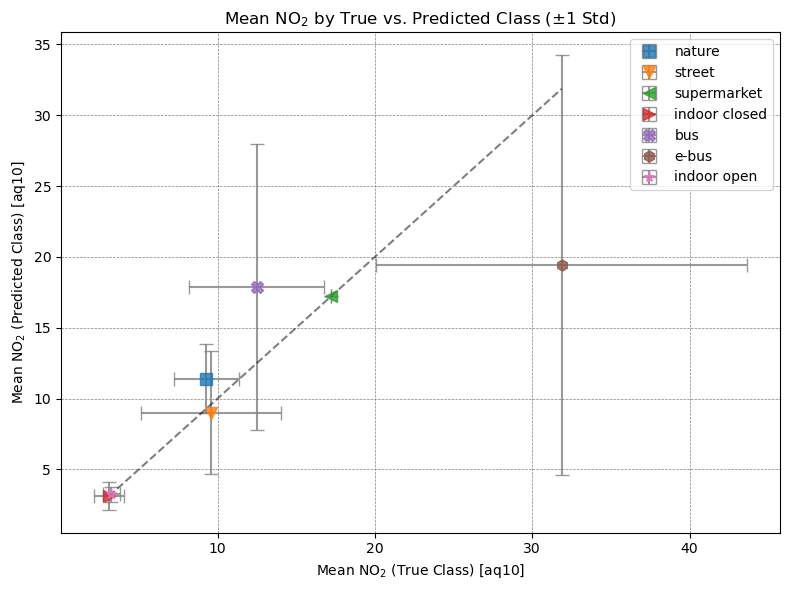

In [4]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------------
# 1) Daten laden (Prediction-CSV, Keras, NO2)
# -------------------------------------------------
CSV_PATH = r"C:\Users\lpera\Downloads\step3.csv"
MODEL_PATH = r"C:\Users\lpera\tf_nn_model.keras"
NO2_CSV_PATH = r"C:\Users\lpera\Downloads\NO2_airquix10-data-2025-02-19 04_01_12.csv"

df = pd.read_csv(CSV_PATH, delimiter=",", encoding="utf-8")
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['status_gt'] = df['status_gt'].astype(str).str.strip().str.lower()

# Label-Mapping
label_mapping = {
    "vehicle in subway": 0,
    "outdoor in nature": 1,
    "indoor in subway-station": 2,
    "outdoor on foot": 3,
    "vehicle in tram": 4,
    "indoor in supermarket": 5,
    "indoor with window closed": 6,
    "vehicle in subway (old)": 7,
    "vehicle in bus": 8,
    "vehicle in e-bus": 9,
    "indoor with window open": 10
}
inv_label_mapping = {v: k for k, v in label_mapping.items()}

# Optionale Kurz-Bezeichnungen
short_label_mapping = {
    "vehicle in subway": "subway",
    "outdoor on foot": "street",
    "indoor in supermarket": "supermarket",
    "vehicle in tram": "tram",
    "indoor with window closed": "indoor closed",
    "indoor in subway-station": "subway-station",
    "vehicle in subway (old)": "subway old",
    "vehicle in bus": "bus",
    "vehicle in e-bus": "e-bus",
    "outdoor in nature": "nature",
    "indoor with window open": "indoor open"
}

# Bestimme Feature-Spalten
FEATURE_COLS = [col for col in df.columns if col not in ["timestamp", "status_gt"]]

# Keras Model laden
model = tf.keras.models.load_model(MODEL_PATH)
print("Model successfully loaded.")

# -------------------------------------------------
# 2) Inferenz (5-Sekunden Takt) + Aggregation
# -------------------------------------------------
predictions = []
for i in range(len(df)):
    input_data = {}
    for col in FEATURE_COLS:
        value = df.loc[i, col]
        if np.issubdtype(df[col].dtype, np.number):
            input_data[col] = np.array([[value]], dtype=np.float32)
        else:
            input_data[col] = tf.convert_to_tensor([[str(value)]], dtype=tf.string)
    pred = model.predict(input_data)
    prob_vector = pred[0]
    pred_class = int(np.argmax(prob_vector))
    confidence = float(prob_vector[pred_class])
    predictions.append((df.loc[i, 'timestamp'], pred_class, confidence))

pred_df = pd.DataFrame(predictions, columns=['timestamp', 'pred_mode_class', 'confidence'])

# Aggregation auf 2-Minuten-Basis: Vorhergesagte Klasse (Modus)
pred_df['minute'] = pred_df['timestamp'].dt.floor('2min')
pred_minute = pred_df.groupby('minute').agg(
    pred_mode_class=pd.NamedAgg(column='pred_mode_class', aggfunc=lambda x: x.mode().iloc[0]),
    avg_confidence=pd.NamedAgg(column='confidence', aggfunc='mean')
).reset_index()

# -------------------------------------------------
# 3) Ground Truth ebenfalls auf 2-Minuten-Basis
# -------------------------------------------------
# (A) Numerische Klassen
df['true_status_num'] = df['status_gt'].map(label_mapping)

# (B) Aggregation pro 2 Minuten (GT-Klasse)
df['minute'] = df['timestamp'].dt.floor('2min')
true_minute = df.groupby('minute').agg(
    true_mode_status=pd.NamedAgg(column='true_status_num', aggfunc=lambda x: x.mode().iloc[0])
).reset_index()

# -------------------------------------------------
# 4) NO2 Daten laden und auf 2-Minuten mitteln
# -------------------------------------------------
df_no2 = pd.read_csv(NO2_CSV_PATH, parse_dates=["Time"]).sort_values(by="Time")

manual_start_time = pd.Timestamp("2025-02-18 13:35:00")

# Filter
pred_minute_filtered = pred_minute[pred_minute['minute'] >= manual_start_time].copy()
true_minute_filtered = true_minute[true_minute['minute'] >= manual_start_time].copy()

df_no2_filtered = df_no2[df_no2['Time'] >= manual_start_time].copy()
df_no2_filtered['minute'] = df_no2_filtered['Time'].dt.floor('2min')

no2_agg_2min = df_no2_filtered.groupby('minute')['no2_aq10'].mean().reset_index()
no2_agg_2min.rename(columns={'no2_aq10': 'no2_mean'}, inplace=True)

# -------------------------------------------------
# 5) Merge: NO2 + Predictions
# -------------------------------------------------
merged_pred = pd.merge(
    pred_minute_filtered[['minute','pred_mode_class']],
    no2_agg_2min,
    on='minute',
    how='inner'
)

# Merge: NO2 + Ground Truth
merged_gt = pd.merge(
    true_minute_filtered[['minute','true_mode_status']],
    no2_agg_2min,
    on='minute',
    how='inner'
)

# -------------------------------------------------
# 6) Mittelwert/Std NO2 pro Klasse (Pred + GT)
# -------------------------------------------------
stats_pred = merged_pred.groupby('pred_mode_class')['no2_mean'].agg(['mean','std']).reset_index()
stats_pred.rename(columns={'mean':'mean_pred','std':'std_pred','pred_mode_class':'class_id'}, inplace=True)

stats_gt = merged_gt.groupby('true_mode_status')['no2_mean'].agg(['mean','std']).reset_index()
stats_gt.rename(columns={'mean':'mean_gt','std':'std_gt','true_mode_status':'class_id'}, inplace=True)

# (A) Merge beider Stats: pro class_id => mean_pred, std_pred, mean_gt, std_gt
stats_both = pd.merge(stats_pred, stats_gt, on='class_id', how='outer').fillna(0)

# Optionale Sortierung nach class_id
stats_both.sort_values(by='class_id', inplace=True)

# Beispiel: Dictionary oder Liste an Markern für max. 11 Klassen
markers = ["o", "s", "^", "v", "D", "<", ">", "p", "X", "h", "*"]

def get_short_label(class_id):
    """Klassen-ID -> Kurzname."""
    original_name = inv_label_mapping.get(class_id, "Unknown")
    return short_label_mapping.get(original_name, original_name)

# 1) Figure anlegen
fig, ax = plt.subplots(figsize=(8, 6))

# 2) Pro Klasse separat plotten
unique_classes = stats_both['class_id'].unique()
unique_classes = np.sort(unique_classes)  # optional: sortieren

for c in unique_classes:
    # Datenzeilen für Klasse c
    data_c = stats_both[stats_both['class_id'] == c]
    
    # x/y + Fehlerbalken
    x = data_c['mean_gt']
    y = data_c['mean_pred']
    xerr = data_c['std_gt']
    yerr = data_c['std_pred']
    
    # Marker wählen (ggf. fallback, wenn c >= len(markers))
    marker_c = markers[c] if c < len(markers) else "o"
    
    # Klassenname für die Legende
    label_c = get_short_label(c)

    ax.errorbar(
        x, y,
        xerr=xerr, yerr=yerr,
        fmt=marker_c, capsize=5,
        ecolor='gray', markersize=8,
        alpha=0.8,
        label=label_c  # -> Legendeintrag
    )

# 3) Diagonale y=x
all_x = stats_both['mean_gt']
all_y = stats_both['mean_pred']
min_val = min(all_x.min(), all_y.min())
max_val = max(all_x.max(), all_y.max())
ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)

# 4) Achsenbeschriftung und Titel (mit Einheit [aq10])
ax.set_xlabel("Mean NO$_2$ (True Class) [aq10]")
ax.set_ylabel("Mean NO$_2$ (Predicted Class) [aq10]")
ax.set_title("Mean NO$_2$ by True vs. Predicted Class (±1 Std)")

# 5) Legende
ax.legend(loc='best')

# Gitternetzlinien hinzufügen
ax.grid(True, color='gray', linestyle='--', linewidth=0.5)

# 6) Layout und Plot speichern
plt.tight_layout()
plt.savefig("mean_NO2_pred_vs_true.png", dpi=300, bbox_inches="tight")

# 7) Plot anzeigen
plt.show()


Model successfully loaded.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


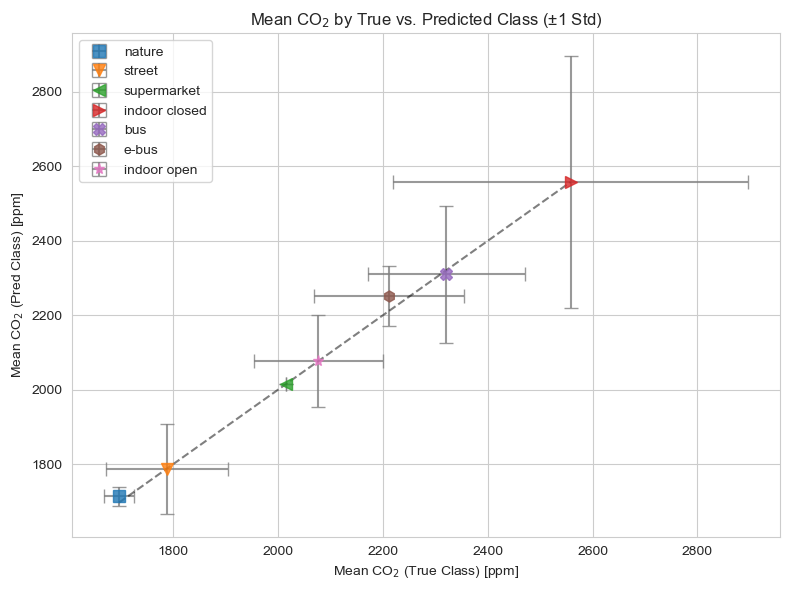

In [6]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------------
# 1) CSVs loading (Predictions + CO₂)
# -------------------------------------------------

# Pfade anpassen
CSV_PATH = r"C:\Users\lpera\Downloads\step3.csv"
MODEL_PATH = r"C:\Users\lpera\tf_nn_model.keras"
CO2_CSV_PATH = r"C:\Users\lpera\Downloads\CO2_airquix10-data-2025-02-19 04_04_40.csv"

df = pd.read_csv(CSV_PATH, delimiter=",", encoding="utf-8")
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['status_gt'] = df['status_gt'].astype(str).str.strip().str.lower()

# Label-Mapping
label_mapping = {
    "vehicle in subway": 0,
    "outdoor in nature": 1,
    "indoor in subway-station": 2,
    "outdoor on foot": 3,
    "vehicle in tram": 4,
    "indoor in supermarket": 5,
    "indoor with window closed": 6,
    "vehicle in subway (old)": 7,
    "vehicle in bus": 8,
    "vehicle in e-bus": 9,
    "indoor with window open": 10
}
inv_label_mapping = {v: k for k, v in label_mapping.items()}

# Kurze Bezeichnungen (Anpassung nach Bedarf)
short_label_mapping = {
    "vehicle in subway": "subway",
    "outdoor on foot": "street",
    "indoor in supermarket": "supermarket",
    "vehicle in tram": "tram",
    "indoor with window closed": "indoor closed",
    "indoor in subway-station": "subway-station",
    "vehicle in subway (old)": "subway old",
    "vehicle in bus": "bus",
    "vehicle in e-bus": "e-bus",
    "outdoor in nature": "nature",
    "indoor with window open": "indoor open"
}

# Feature-Spalten
FEATURE_COLS = [col for col in df.columns if col not in ["timestamp", "status_gt"]]

# Keras Modell laden
model = tf.keras.models.load_model(MODEL_PATH)
print("Model successfully loaded.")

# -------------------------------------------------
# 2) Inferenz (5-Sekunden Takt) + Aggregation
# -------------------------------------------------
predictions = []
for i in range(len(df)):
    input_data = {}
    for col in FEATURE_COLS:
        value = df.loc[i, col]
        if np.issubdtype(df[col].dtype, np.number):
            input_data[col] = np.array([[value]], dtype=np.float32)
        else:
            input_data[col] = tf.convert_to_tensor([[str(value)]], dtype=tf.string)
    pred = model.predict(input_data)
    prob_vector = pred[0]
    pred_class = int(np.argmax(prob_vector))
    confidence = float(prob_vector[pred_class])
    predictions.append((df.loc[i, 'timestamp'], pred_class, confidence))

pred_df = pd.DataFrame(predictions, columns=['timestamp', 'pred_mode_class', 'confidence'])

# -> 2-Minuten-Intervalle
pred_df['minute'] = pred_df['timestamp'].dt.floor('2min')

# Aggregation: Modus-Klasse, mittlere Confidence
pred_minute = pred_df.groupby('minute').agg(
    pred_mode_class=pd.NamedAgg(column='pred_mode_class', aggfunc=lambda x: x.mode().iloc[0]),
    avg_confidence=pd.NamedAgg(column='confidence', aggfunc='mean')
).reset_index()

# -------------------------------------------------
# 3) CO₂-Daten laden
# -------------------------------------------------
df_co2 = pd.read_csv(CO2_CSV_PATH, parse_dates=["Time"]).sort_values(by="Time")

manual_start_time = pd.Timestamp("2025-02-18 13:30:00")

# Predictions filtern (2-Min)
pred_minute_filtered = pred_minute[pred_minute['minute'] >= manual_start_time].copy()

# CO₂ filtern
df_co2_filtered = df_co2[df_co2['Time'] >= manual_start_time].copy()
df_co2_filtered['minute'] = df_co2_filtered['Time'].dt.floor('2min')

# -> ALLE CO₂-Werte im 2-Min-Fenster beibehalten, damit wir eine Std > 0 kriegen
merged_pred = pd.merge(
    pred_minute_filtered[['minute','pred_mode_class']],
    df_co2_filtered[['minute','CO2_ppm']],
    on='minute',
    how='inner'
)

# -------------------------------------------------
# 4) Mittelwert + Std pro Klasse (Pred)
# -------------------------------------------------
stats_pred = merged_pred.groupby('pred_mode_class')['CO2_ppm'].agg(['mean','std']).reset_index()
stats_pred.rename(columns={'mean':'mean_pred','std':'std_pred','pred_mode_class':'class_id'}, inplace=True)

# -------------------------------------------------
# 5) Gleicher Prozess für TRUE
# -------------------------------------------------
df['true_status_num'] = df['status_gt'].map(label_mapping)
df['minute'] = df['timestamp'].dt.floor('2min')

true_minute = df.groupby('minute')['true_status_num'].agg(lambda x: x.mode().iloc[0]).reset_index()
true_minute_filtered = true_minute[true_minute['minute'] >= manual_start_time].copy()

merged_true = pd.merge(
    true_minute_filtered[['minute','true_status_num']],
    df_co2_filtered[['minute','CO2_ppm']],
    on='minute',
    how='inner'
)

stats_true = merged_true.groupby('true_status_num')['CO2_ppm'].agg(['mean','std']).reset_index()
stats_true.rename(columns={'mean':'mean_true','std':'std_true','true_status_num':'class_id'}, inplace=True)

# -------------------------------------------------
# 6) Merge Pred + True => stats_both
# -------------------------------------------------
stats_both = pd.merge(stats_pred, stats_true, on='class_id', how='outer').fillna(0)
stats_both.sort_values(by='class_id', inplace=True)

print("\nCO2 Stats Both (Pred vs. True):\n", stats_both)

# -------------------------------------------------
# 7) Scatter-Plot: x=Mean True, y=Mean Pred
# -------------------------------------------------
markers = ["o", "s", "^", "v", "D", "<", ">", "p", "X", "h", "*"]

def get_short_label(class_id):
    # class_id kann float sein -> cast to int
    c_int = int(class_id)
    original_name = inv_label_mapping.get(c_int, "Unknown")
    return short_label_mapping.get(original_name, original_name)

# Optional: Seaborn-Style mit Grid
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(8, 6))

for i, row in stats_both.iterrows():
    c = row['class_id']
    c_int = int(c)  # float -> int
    x = row['mean_true']
    y = row['mean_pred']
    xerr = row['std_true']
    yerr = row['std_pred']

    if c_int < len(markers):
        marker_c = markers[c_int]
    else:
        marker_c = "o"

    label_c = get_short_label(c_int)

    ax.errorbar(
        x, y,
        xerr=xerr, yerr=yerr,
        fmt=marker_c, capsize=5,
        ecolor='gray', markersize=8,
        alpha=0.8,
        label=label_c
    )

all_x = stats_both['mean_true']
all_y = stats_both['mean_pred']
min_val = min(all_x.min(), all_y.min())
max_val = max(all_x.max(), all_y.max())

ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)

ax.set_xlabel("Mean CO$_2$ (True Class) [ppm]")
ax.set_ylabel("Mean CO$_2$ (Pred Class) [ppm]")
ax.set_title("Mean CO$_2$ by True vs. Predicted Class (±1 Std)")

ax.legend(loc='best')

plt.tight_layout()
plt.savefig("co2_mean_pred_vs_true.png", dpi=300, bbox_inches="tight")
plt.show()


Model successfully loaded.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━

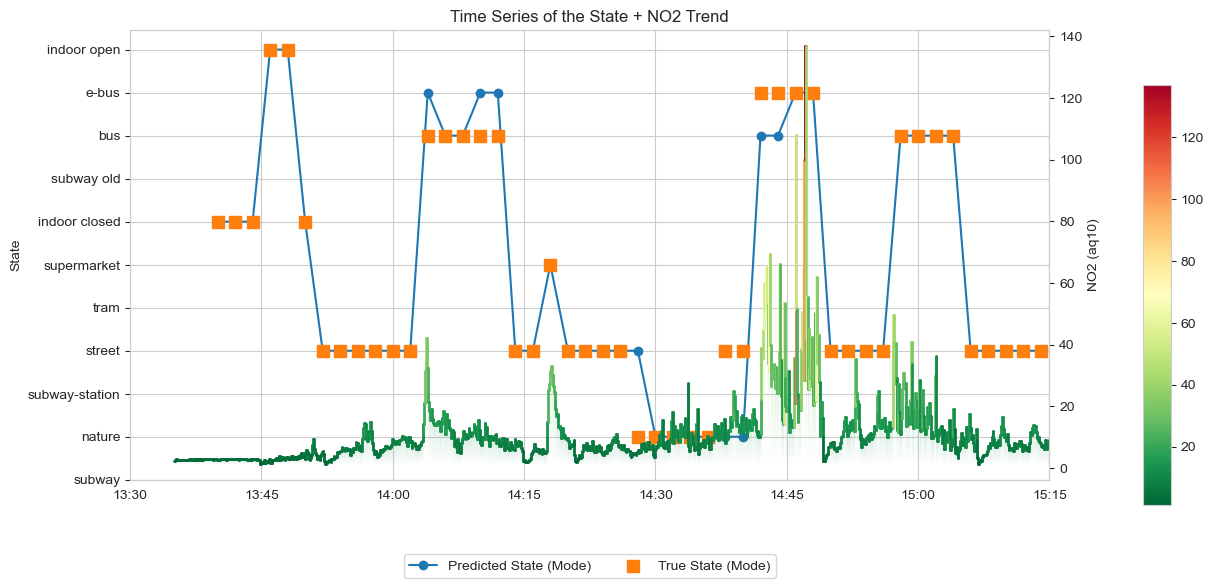

Datenbereich merged_df_filtered: 2025-02-18 13:40:00 2025-02-18 15:14:00
Datenbereich df_no2_filtered: 2025-02-18 13:35:00 2025-02-19 02:07:05


In [9]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# ------------------------------------------
# 1) CSVs loading (Predictions + NO₂)
# ------------------------------------------

# Pfade (deine anpassen)
CSV_PATH = r"C:\Users\lpera\Downloads\step3.csv"
MODEL_PATH = r"C:\Users\lpera\tf_nn_model.keras"
NO2_CSV_PATH = r"C:\Users\lpera\Downloads\NO2_airquix10-data-2025-02-19 04_01_12.csv"

# Label-Mappings
label_mapping = {
    "vehicle in subway": 0,
    "outdoor in nature": 1,
    "indoor in subway-station": 2,
    "outdoor on foot": 3,
    "vehicle in tram": 4,
    "indoor in supermarket": 5,
    "indoor with window closed": 6,
    "vehicle in subway (old)": 7,
    "vehicle in bus": 8,
    "vehicle in e-bus": 9,
    "indoor with window open": 10
}
inv_label_mapping = {v: k for k, v in label_mapping.items()}

short_label_mapping = {
    "vehicle in subway": "subway",
    "outdoor on foot": "street",
    "indoor in supermarket": "supermarket",
    "vehicle in tram": "tram",
    "indoor with window closed": "indoor closed",
    "indoor in subway-station": "subway-station",
    "vehicle in subway (old)": "subway old",
    "vehicle in bus": "bus",
    "vehicle in e-bus": "e-bus",
    "outdoor in nature": "nature",
    "indoor with window open": "indoor open"
}

# 1.1) Predictions CSV laden
df = pd.read_csv(CSV_PATH, delimiter=",", encoding="utf-8")
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['status_gt'] = df['status_gt'].astype(str).str.strip().str.lower()

FEATURE_COLS = [col for col in df.columns if col not in ["timestamp", "status_gt"]]

# 1.2) Keras Modell laden
model = tf.keras.models.load_model(MODEL_PATH)
print("Model successfully loaded.")

# 1.3) Inferenz
predictions = []
num_rows = len(df)
for i in range(num_rows):
    input_data = {}
    for col in FEATURE_COLS:
        value = df.loc[i, col]
        if np.issubdtype(df[col].dtype, np.number):
            input_data[col] = np.array([[value]], dtype=np.float32)
        else:
            input_data[col] = tf.convert_to_tensor([[str(value)]], dtype=tf.string)
    pred = model.predict(input_data)
    prob_vector = pred[0]
    pred_class = int(np.argmax(prob_vector))
    confidence = float(prob_vector[pred_class])
    predictions.append((df.loc[i, 'timestamp'], pred_class, confidence))

pred_df = pd.DataFrame(predictions, columns=['timestamp', 'pred_mode_class', 'confidence'])

# 1.4) Aggregation pro 2 Minuten
pred_df['minute'] = pred_df['timestamp'].dt.floor('2min')
pred_minute = pred_df.groupby('minute').agg(
    pred_mode_class=pd.NamedAgg(column='pred_mode_class', aggfunc=lambda x: x.mode().iloc[0]),
    avg_confidence=pd.NamedAgg(column='confidence', aggfunc='mean')
).reset_index()

# 1.5) True Values aggregieren
df['true_status_num'] = df['status_gt'].map(label_mapping)
true_minute = df.groupby(df['timestamp'].dt.floor('2min')).agg(
    true_mode_status=pd.NamedAgg(
        column='true_status_num',
        aggfunc=lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
    )
).reset_index().rename(columns={'timestamp': 'minute'})

# 1.6) Merge
merged_df = pd.merge(pred_minute, true_minute, on='minute', how='inner')
print("Merged dataframe head:")
print(merged_df.head())

# 1.7) NO₂ Daten
df_no2 = pd.read_csv(NO2_CSV_PATH, parse_dates=["Time"]).sort_values(by="Time")
times_no2_all = df_no2["Time"].to_numpy()
vals_no2_all  = df_no2["no2_aq10"].to_numpy()

# ------------------------------------------
# Manueller Start (z.B. 13:35) + Filter
# ------------------------------------------
manual_start_time = pd.Timestamp("2025-02-18 13:35:00")
merged_df_filtered = merged_df[merged_df['minute'] >= manual_start_time]

df_no2_filtered = df_no2[df_no2['Time'] >= manual_start_time]
times_no2 = df_no2_filtered["Time"].to_numpy()
vals_no2  = df_no2_filtered["no2_aq10"].to_numpy()

# ------------------------------------------
# 2) Plot (Klassen + NO₂)
# ------------------------------------------
sns.set_style("whitegrid")
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))

# (A) Predicted vs. True Class
ax1.plot(
    merged_df_filtered['minute'], 
    merged_df_filtered['pred_mode_class'],
    marker='o', linestyle='-', color='tab:blue',
    label='Predicted State (Mode)',
    zorder=10  # Status-Linie oben
)
ax1.scatter(
    merged_df_filtered['minute'], 
    merged_df_filtered['true_mode_status'],
    color='tab:orange', marker='s', s=80,
    label='True State (Mode)',
    zorder=11  # Scatter-Punkte noch darüber
)

ax1.set_ylabel("State")
ax1.set_title("Time Series of the State + NO$_2$Trend")

# Legende
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

# Y-Ticks 0..10
all_classes = sorted(label_mapping.values())
ax1.set_yticks(all_classes)
ax1.set_yticklabels([
    short_label_mapping.get(inv_label_mapping.get(cls, "Unknown"), "Unknown")
    for cls in all_classes
])

# (B) NO₂ auf zweiter Achse
ax_no2 = ax1.twinx()
ax_no2.grid(False)

if len(times_no2) > 0:
    cmap = plt.get_cmap("RdYlGn_r")
    norm = plt.Normalize(vals_no2.min(), vals_no2.max())

    n_stripes = 25
    y_min = vals_no2.min()

    for i in range(len(vals_no2) - 1):
        x1_ = times_no2[i]
        x2_ = times_no2[i+1]
        y1_ = vals_no2[i]
        y2_ = vals_no2[i+1]

        # Linie horizontal
        color_h = cmap(norm(y1_))
        ax_no2.plot([x1_, x2_], [y1_, y1_], color=color_h, linewidth=2, zorder=2)

        # Linie vertikal
        color_v = cmap(norm(y2_))
        ax_no2.plot([x2_, x2_], [y1_, y2_], color=color_v, linewidth=2, zorder=2)

        # Füllung (Streifen) - optional alpha anpassen
        levels = np.linspace(y_min, y1_, n_stripes + 1)
        for s in range(n_stripes):
            bottom = levels[s]
            top = levels[s+1]
            alpha_val = 0.15 * ((s+1)/n_stripes)  # etwas durchsichtiger
            ax_no2.fill_between(
                [x1_, x2_], top, bottom,
                facecolor=color_h, alpha=alpha_val,
                edgecolor='none',
                zorder=1
            )

    ax_no2.set_ylabel("NO$_2$ (aq10)")
    padding = 5
    ax_no2.set_ylim(y_min - padding, vals_no2.max() + padding)
else:
    print("No NO2 data available after manual_start_time.")
    ax_no2.set_ylabel("NO$_2$ (aq10)")

# ------------------------------------------
# 3) X-Achsen-Format & Colorbar
# ------------------------------------------
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

# ### HIER das Zeitfenster für den Plot anpassen ###
start_plot = pd.Timestamp("2025-02-18 13:30:00")
end_plot   = pd.Timestamp("2025-02-18 15:15:00")
ax1.set_xlim(start_plot, end_plot)

fig.tight_layout(rect=[0, 0, 0.8, 1])

# Colorbar rechts
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
if len(times_no2) > 0:
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
else:
    sm = plt.cm.ScalarMappable()
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)

# X-Achse-Ticks drehen
fig.autofmt_xdate(rotation=45)

# 4) Plot speichern
plt.savefig("NO2_plot.png", dpi=300, bbox_inches="tight")

# 5) Plot anzeigen
plt.show()

# --- Zusätzlicher Datencheck ---
print("Datenbereich merged_df_filtered:", 
      merged_df_filtered['minute'].min(), 
      merged_df_filtered['minute'].max())
print("Datenbereich df_no2_filtered:", 
      df_no2_filtered['Time'].min(), 
      df_no2_filtered['Time'].max())


Model successfully loaded.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━

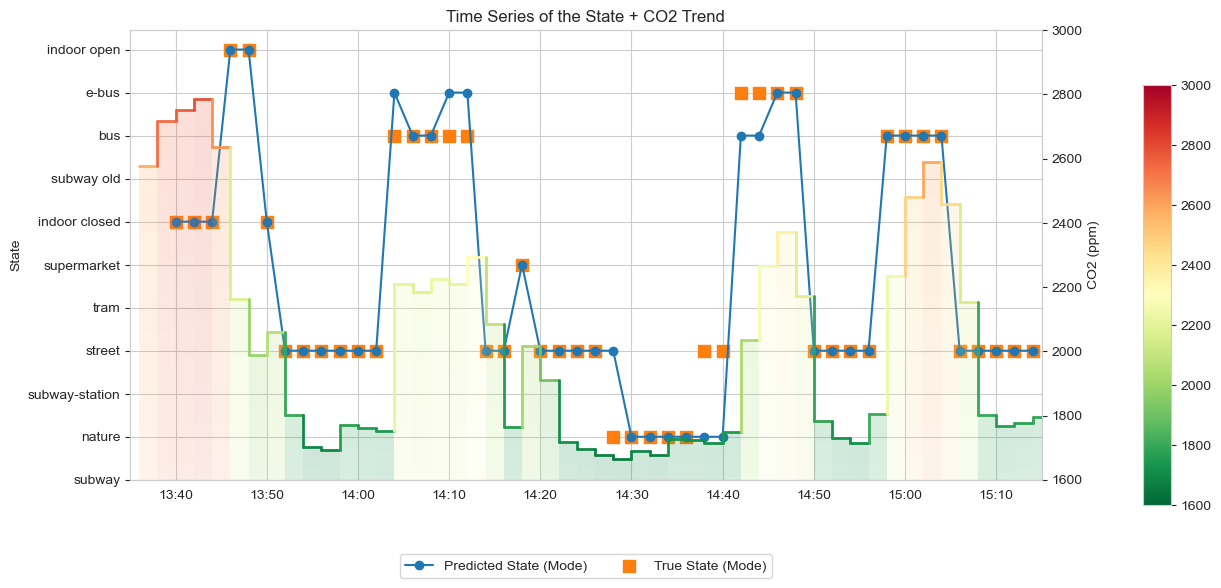

merged_df_filtered range: 2025-02-18 13:40:00 2025-02-18 15:14:00
df_co2_filtered range: 2025-02-18 13:36:00 2025-02-19 02:06:00


In [1]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# ------------------------------------------
# 1) CSVs loading (Predictions + CO₂)
# ------------------------------------------

# Paths (anpassen)
CSV_PATH = r"C:\Users\lpera\Downloads\step3.csv"
MODEL_PATH = r"C:\Users\lpera\tf_nn_model.keras"
CO2_CSV_PATH = r"C:\Users\lpera\Downloads\CO2_airquix10-data-2025-02-19 04_04_40.csv"

# Label-Mapping
label_mapping = {
    "vehicle in subway": 0,
    "outdoor in nature": 1,
    "indoor in subway-station": 2,
    "outdoor on foot": 3,
    "vehicle in tram": 4,
    "indoor in supermarket": 5,
    "indoor with window closed": 6,
    "vehicle in subway (old)": 7,
    "vehicle in bus": 8,
    "vehicle in e-bus": 9,
    "indoor with window open": 10
}
inv_label_mapping = {v: k for k, v in label_mapping.items()}

# Kurze Bezeichnungen (Anpassung nach Bedarf)
short_label_mapping = {
    "vehicle in subway": "subway",
    "outdoor on foot": "street",
    "indoor in supermarket": "supermarket",
    "vehicle in tram": "tram",
    "indoor with window closed": "indoor closed",
    "indoor in subway-station": "subway-station",
    "vehicle in subway (old)": "subway old",
    "vehicle in bus": "bus",
    "vehicle in e-bus": "e-bus",
    "outdoor in nature": "nature",
    "indoor with window open": "indoor open"
}

# 1.1) Lade die Predictions-CSV
df = pd.read_csv(CSV_PATH, delimiter=",", encoding="utf-8")
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['status_gt'] = df['status_gt'].astype(str).str.strip().str.lower()

# Bestimme die Feature-Spalten
FEATURE_COLS = [col for col in df.columns if col not in ["timestamp", "status_gt"]]

# 1.2) Lade das Keras Model
model = tf.keras.models.load_model(MODEL_PATH)
print("Model successfully loaded.")

# 1.3) Führe Inferenz für jede Zeile durch (5-Sekunden Intervalle)
predictions = []
num_rows = len(df)
for i in range(num_rows):
    input_data = {}
    for col in FEATURE_COLS:
        value = df.loc[i, col]
        if np.issubdtype(df[col].dtype, np.number):
            input_data[col] = np.array([[value]], dtype=np.float32)
        else:
            input_data[col] = tf.convert_to_tensor([[str(value)]], dtype=tf.string)
    pred = model.predict(input_data)
    prob_vector = pred[0]
    pred_class = int(np.argmax(prob_vector))
    confidence = float(prob_vector[pred_class])
    predictions.append((df.loc[i, 'timestamp'], pred_class, confidence))

pred_df = pd.DataFrame(predictions, columns=['timestamp', 'pred_mode_class', 'confidence'])

# 1.4) Aggregiere Predictions pro 2 Minuten
pred_df['minute'] = pred_df['timestamp'].dt.floor('2min')
pred_minute = pred_df.groupby('minute').agg(
    pred_mode_class=pd.NamedAgg(column='pred_mode_class', aggfunc=lambda x: x.mode().iloc[0]),
    avg_confidence=pd.NamedAgg(column='confidence', aggfunc='mean')
).reset_index()

# 1.5) True Values (ebenfalls pro 2 Minuten)
df['true_status_num'] = df['status_gt'].map(label_mapping)
true_minute = df.groupby(df['timestamp'].dt.floor('2min')).agg(
    true_mode_status=pd.NamedAgg(
        column='true_status_num',
        aggfunc=lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
    )
).reset_index().rename(columns={'timestamp': 'minute'})

# 1.6) Merge
merged_df = pd.merge(pred_minute, true_minute, on='minute', how='inner')
print("Merged dataframe head:")
print(merged_df.head())

# 1.7) CO₂ Daten laden
df_co2 = pd.read_csv(CO2_CSV_PATH, parse_dates=["Time"]).sort_values(by="Time")
times_co2_all = df_co2["Time"].to_numpy()
vals_co2_all  = df_co2["CO2_ppm"].to_numpy()

# ------------------------------------------
# MANUAL START TIME
# ------------------------------------------
manual_start_time = pd.Timestamp("2025-02-18 13:35:00")  # Beispiel

# Filtere merged_df auf Daten nach der manuellen Startzeit
merged_df_filtered = merged_df[merged_df['minute'] >= manual_start_time]

# Filtere auch die CO₂ Daten entsprechend
df_co2_filtered = df_co2[df_co2['Time'] >= manual_start_time]
times_co2 = df_co2_filtered["Time"].to_numpy()
vals_co2  = df_co2_filtered["CO2_ppm"].to_numpy()

# ------------------------------------------
# 2) Plot: 1 Subplot (Klassen + CO₂)
# ------------------------------------------
sns.set_style("whitegrid")
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))

# (A) Predicted vs. True Class (linke Achse)
ax1.plot(
    merged_df_filtered['minute'],
    merged_df_filtered['pred_mode_class'],
    marker='o', linestyle='-', color='tab:blue',
    label='Predicted State (Mode)'
)
ax1.scatter(
    merged_df_filtered['minute'],
    merged_df_filtered['true_mode_status'],
    color='tab:orange', marker='s', s=80,
    label='True State (Mode)'
)

ax1.set_ylabel("State")
ax1.set_title("Time Series of the State + CO$_2$ Trend")

# Legende (optional) unten platzieren
ax1.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=2
)

# Y-Ticks für Klassen 0..10
all_classes = sorted(label_mapping.values())
ax1.set_yticks(all_classes)
ax1.set_yticklabels([
    short_label_mapping.get(inv_label_mapping.get(cls, "Unknown"), "Unknown")
    for cls in all_classes
])

# (B) CO₂ Daten auf der rechten Achse
ax_co2 = ax1.twinx()  # zweite y-Achse für CO₂
ax_co2.grid(False)

if len(times_co2) > 0:
    cmap = plt.get_cmap("RdYlGn_r")
    # Farbskala fest auf 0..3000
    norm = plt.Normalize(1600, 3000)

    n_stripes = 25

    # Y-Achse für CO₂ ebenfalls 0..3000
    ax_co2.set_ylim(1600, 3000)

    # Step-Plot mit pseudo-Gradient
    for i in range(len(vals_co2) - 1):
        x1_ = times_co2[i]
        x2_ = times_co2[i+1]
        y1_ = vals_co2[i]
        y2_ = vals_co2[i+1]

        # 1) Horizontale Linie
        color_h = cmap(norm(min(y1_, 3000)))  # Werte >3000 werden gekappt
        ax_co2.plot([x1_, x2_], [y1_, y1_], color=color_h, linewidth=2)

        # 2) Vertikale Linie
        color_v = cmap(norm(min(y2_, 3000)))
        ax_co2.plot([x2_, x2_], [y1_, y2_], color=color_v, linewidth=2)

        # 3) Füllung (Streifen)
        # Falls du ab 0 füllen möchtest:
        bottom_level = 0
        top_level = y1_

        # Falls y1_ > 3000, kappen auf 3000
        if top_level > 3000:
            top_level = 3000

        levels = np.linspace(bottom_level, top_level, n_stripes + 1)
        for s in range(n_stripes):
            bottom = levels[s]
            top = levels[s+1]
            alpha_val = 0.2 * ((s+1)/n_stripes)
            ax_co2.fill_between(
                [x1_, x2_], top, bottom,
                facecolor=color_h, alpha=alpha_val,
                edgecolor='none'
            )

    ax_co2.set_ylabel("CO$_2$ (ppm)")
else:
    print("No CO2 data available after manual_start_time.")
    ax_co2.set_ylabel("CO$_2$ (ppm)")

# ------------------------------------------
# 3) Layout / X-Axis Format & Colorbar
# ------------------------------------------
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

# ------------------------------------------------
# (A) Begrenze hier den Plot-Zeitraum, z.B. 13:30–14:40
# ------------------------------------------------
start_plot = pd.Timestamp("2025-02-18 13:35:00")
end_plot   = pd.Timestamp("2025-02-18 15:15:00")
ax1.set_xlim(start_plot, end_plot)

# (1) Passe das Layout an (maximal 80% der Breite)
fig.tight_layout(rect=[0, 0, 0.8, 1])

# (2) Separate Achse für die Colorbar (rechts)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])

# (3) Erstelle die Colorbar
if len(times_co2) > 0:
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
else:
    sm = plt.cm.ScalarMappable()
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)

# Optional: Drehe die x-Achsen-Ticks für bessere Lesbarkeit
fig.autofmt_xdate(rotation=45)

# 4) Plot speichern (PNG, 300 DPI)
plt.savefig("CO2_plot.png", dpi=300, bbox_inches="tight")

# Falls die Legende unten abgeschnitten wird, kannst du vorher:
# plt.subplots_adjust(bottom=0.3)

# 5) Zeige den Plot an
plt.show()

# ------------------------------------------
# Datencheck (optional):
# ------------------------------------------
print("merged_df_filtered range:", 
      merged_df_filtered['minute'].min(), 
      merged_df_filtered['minute'].max())
print("df_co2_filtered range:", 
      df_co2_filtered['Time'].min(), 
      df_co2_filtered['Time'].max())


Model successfully loaded.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1

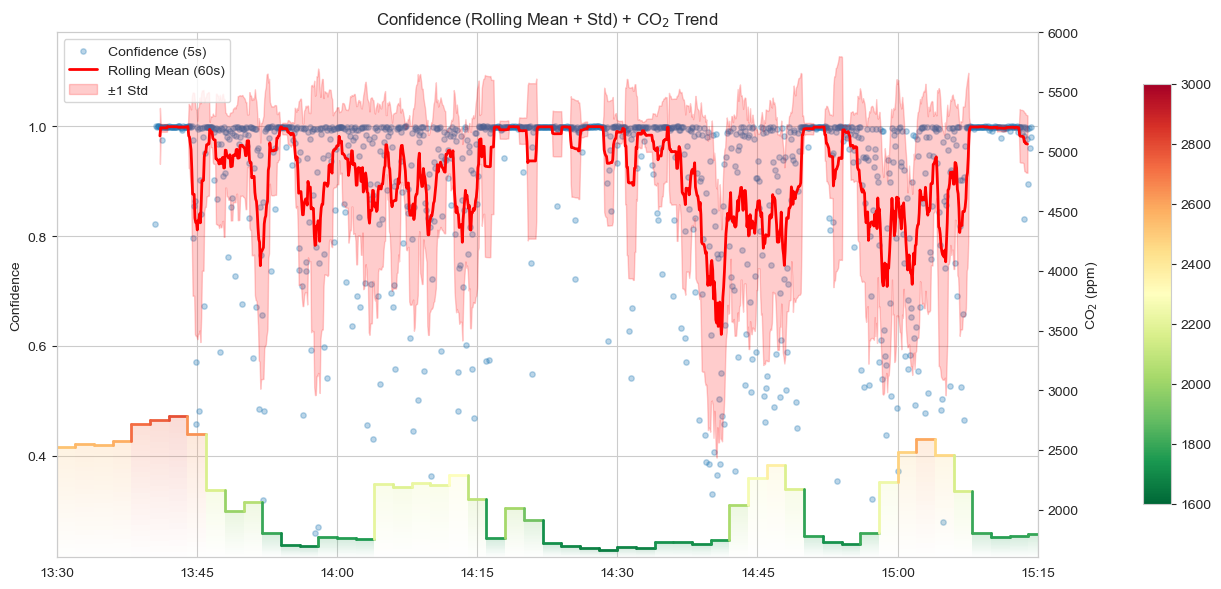

In [3]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# -------------------------------------------------
# 1) Daten laden (Prediction-CSV, Keras, CO2)
# -------------------------------------------------
CSV_PATH = r"C:\Users\lpera\Downloads\step3.csv"
MODEL_PATH = r"C:\Users\lpera\tf_nn_model.keras"
CO2_CSV_PATH = r"C:\Users\lpera\Downloads\CO2_airquix10-data-2025-02-19 04_04_40.csv"

df = pd.read_csv(CSV_PATH, delimiter=",", encoding="utf-8")
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Beispiel: Feature-Spalten herausfiltern
FEATURE_COLS = [col for col in df.columns if col not in ["timestamp", "status_gt"]]

# Keras Modell laden
model = tf.keras.models.load_model(MODEL_PATH)
print("Model successfully loaded.")

# -------------------------------------------------
# 1.3) Inferenz (5-Sekunden-Intervalle)
# -------------------------------------------------
predictions = []
for i in range(len(df)):
    input_data = {}
    for col in FEATURE_COLS:
        value = df.loc[i, col]
        if np.issubdtype(df[col].dtype, np.number):
            input_data[col] = np.array([[value]], dtype=np.float32)
        else:
            input_data[col] = tf.convert_to_tensor([[str(value)]], dtype=tf.string)
    pred = model.predict(input_data)
    prob_vector = pred[0]
    pred_class = int(np.argmax(prob_vector))
    confidence = float(prob_vector[pred_class])
    predictions.append((df.loc[i, 'timestamp'], pred_class, confidence))

pred_df = pd.DataFrame(predictions, columns=['timestamp', 'pred_mode_class', 'confidence'])

# CO₂-Daten
df_co2 = pd.read_csv(CO2_CSV_PATH, parse_dates=["Time"]).sort_values(by="Time")

# -------------------------------------------------
# 2) Daten filtern / Rolling Mean & Std
# -------------------------------------------------
manual_start_time = pd.Timestamp("2025-02-18 13:30:00")

# Confidence-DataFrame filtern
pred_df_filtered = pred_df[pred_df['timestamp'] >= manual_start_time].copy()

# Gleitender Mittelwert und Std (Fenster = 12 → ~60 Sekunden, falls 5s pro Punkt)
pred_df_filtered['confidence_smooth'] = pred_df_filtered['confidence'].rolling(window=12, center=True).mean()
pred_df_filtered['confidence_std'] = pred_df_filtered['confidence'].rolling(window=12, center=True).std()

# CO₂ filtern
df_co2_filtered = df_co2[df_co2['Time'] >= manual_start_time].copy()
times_co2 = df_co2_filtered["Time"].to_numpy()
vals_co2  = df_co2_filtered["CO2_ppm"].to_numpy()

# -------------------------------------------------
# 3) Plot: Confidence (links) + CO₂ (rechts)
# -------------------------------------------------
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(14,6))

# 3.1) Scatter für Confidence (5s)
ax.scatter(
    pred_df_filtered['timestamp'],
    pred_df_filtered['confidence'],
    color='tab:blue', marker='o', s=15, alpha=0.3,
    label='Confidence (5s)'
)

# 3.2) Rolling Mean als rote Linie
ax.plot(
    pred_df_filtered['timestamp'],
    pred_df_filtered['confidence_smooth'],
    color='red', linewidth=2, label='Rolling Mean (60s)'
)

# 3.3) ±1 Standardabweichung als Füllung
ax.fill_between(
    pred_df_filtered['timestamp'],
    pred_df_filtered['confidence_smooth'] - pred_df_filtered['confidence_std'],
    pred_df_filtered['confidence_smooth'] + pred_df_filtered['confidence_std'],
    color='red', alpha=0.2,
    label='±1 Std'
)

# Achse (links)
ax.set_ylabel("Confidence")
ax.set_title("Confidence (Rolling Mean + Std) + CO$_2$ Trend")
ax.legend(loc='upper left')

# -------------------------------------------------
# 3.4) CO₂ mit Gradient auf der rechten Achse
# -------------------------------------------------
ax2 = ax.twinx()
ax2.grid(False)

if len(times_co2) > 1:
    # Farbskala: 1600..3000 (bleibt gleich)
    cmap = plt.get_cmap("RdYlGn_r")
    norm = plt.Normalize(1600, 3000)

    # Y-Achse: 1600..6000 (abgeschnitten bei 6000)
    ax2.set_ylim(1600, 6000)

    n_stripes = 25
    for i in range(len(vals_co2) - 1):
        x1_ = times_co2[i]
        x2_ = times_co2[i+1]
        y1_ = vals_co2[i]
        y2_ = vals_co2[i+1]

        # Für die Farbe deckeln wir bei 3000
        color_h = cmap(norm(min(y1_, 3000)))
        color_v = cmap(norm(min(y2_, 3000)))

        # 1) Horizontale Linie (echte Werte, Farbe max. bis 3000)
        ax2.plot([x1_, x2_], [y1_, y1_], color=color_h, linewidth=2)

        # 2) Vertikale Linie
        ax2.plot([x2_, x2_], [y1_, y2_], color=color_v, linewidth=2)

        # 3) Füllung (Streifen) - von 1600 bis y1_ (falls y1_ <6000, sonst abgeschnitten)
        bottom_level = 1600
        top_level = y1_  # wir plotten den echten Wert

        if top_level < 1600:
            top_level = 1600

        # (Werte über 6000 sind nicht sichtbar, da Achse abgeschnitten)
        levels = np.linspace(bottom_level, top_level, n_stripes + 1)
        for s in range(n_stripes):
            bottom = levels[s]
            top = levels[s+1]
            alpha_val = 0.2 * ((s+1)/n_stripes)
            ax2.fill_between(
                [x1_, x2_], top, bottom,
                facecolor=color_h, alpha=alpha_val,
                edgecolor='none'
            )

    ax2.set_ylabel("CO$_2$ (ppm)")
else:
    print("No CO2 data available after manual_start_time.")
    ax2.set_ylabel("CO$_2$ (ppm)")

# -------------------------------------------------
# 4) Layout: X-Achse, Zeitfenster, Colorbar
# -------------------------------------------------
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

start_plot = pd.Timestamp("2025-02-18 13:30:00")
end_plot   = pd.Timestamp("2025-02-18 15:15:00")
ax.set_xlim(start_plot, end_plot)

fig.tight_layout(rect=[0, 0, 0.8, 1])

# Colorbar
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
if len(times_co2) > 1:
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
else:
    sm = plt.cm.ScalarMappable()
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)

# X-Achse-Ticks drehen
fig.autofmt_xdate(rotation=45)

# Plot speichern (PNG, 300 DPI)
plt.savefig("CO2_plot_confidence_rolling_std.png", dpi=300, bbox_inches="tight")

# Plot anzeigen
plt.show()


Model successfully loaded.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━

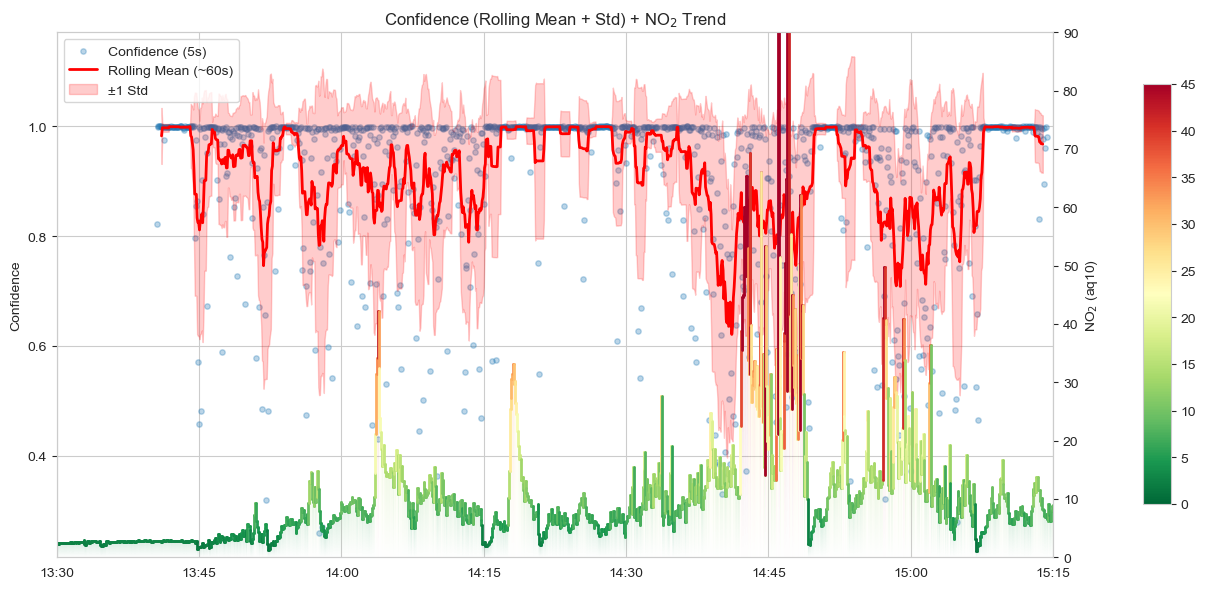

Datenbereich pred_df_filtered: 2025-02-18 13:40:33 2025-02-18 15:14:19
Datenbereich df_no2_filtered: 2025-02-18 13:30:00 2025-02-19 02:07:05


In [11]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# -------------------------------------------------
# 1) Daten laden: Predictions + NO₂
# -------------------------------------------------

# Beispielpfade anpassen
CSV_PATH = r"C:\Users\lpera\Downloads\step3.csv"
MODEL_PATH = r"C:\Users\lpera\tf_nn_model.keras"
NO2_CSV_PATH = r"C:\Users\lpera\Downloads\NO2_airquix10-data-2025-02-19 04_01_12.csv"

# 1.1) Predictions-CSV laden
df = pd.read_csv(CSV_PATH, delimiter=",", encoding="utf-8")
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Features bestimmen
FEATURE_COLS = [col for col in df.columns if col not in ["timestamp", "status_gt"]]

# 1.2) Keras-Modell laden
model = tf.keras.models.load_model(MODEL_PATH)
print("Model successfully loaded.")

# 1.3) Inferenz (5-Sekunden-Intervalle)
predictions = []
for i in range(len(df)):
    input_data = {}
    for col in FEATURE_COLS:
        value = df.loc[i, col]
        if np.issubdtype(df[col].dtype, np.number):
            input_data[col] = np.array([[value]], dtype=np.float32)
        else:
            input_data[col] = tf.convert_to_tensor([[str(value)]], dtype=tf.string)
    pred = model.predict(input_data)
    prob_vector = pred[0]
    pred_class = int(np.argmax(prob_vector))
    confidence = float(prob_vector[pred_class])
    predictions.append((df.loc[i, 'timestamp'], pred_class, confidence))

pred_df = pd.DataFrame(predictions, columns=['timestamp', 'pred_mode_class', 'confidence'])

# 1.7) NO₂-Daten laden
df_no2 = pd.read_csv(NO2_CSV_PATH, parse_dates=["Time"]).sort_values(by="Time")

# -------------------------------------------------
# 2) Daten filtern / Rolling Mean & Std
# -------------------------------------------------
manual_start_time = pd.Timestamp("2025-02-18 13:30:00")

# (A) Confidence filtern und Rolling-Statistiken
pred_df_filtered = pred_df[pred_df['timestamp'] >= manual_start_time].copy()

# Rolling Mean/Std (Fenster 12 ≈ 60 Sek, wenn alle 5s ein Wert)
pred_df_filtered['confidence_smooth'] = pred_df_filtered['confidence'].rolling(window=12, center=True).mean()
pred_df_filtered['confidence_std']    = pred_df_filtered['confidence'].rolling(window=12, center=True).std()

# (B) NO₂ filtern
df_no2_filtered = df_no2[df_no2['Time'] >= manual_start_time].copy()
times_no2 = df_no2_filtered["Time"].to_numpy()
vals_no2  = df_no2_filtered["no2_aq10"].to_numpy()

# -------------------------------------------------
# 3) Plot: Confidence (links) + NO₂ (rechts)
# -------------------------------------------------
sns.set_style("whitegrid")
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))

# --- (A) Confidence Scatter + Rolling Mean/Std auf linker Achse ---
# Scatter: alle 5s Confidence (halbtransparent)
ax1.scatter(
    pred_df_filtered['timestamp'],
    pred_df_filtered['confidence'],
    color='tab:blue', marker='o', s=15, alpha=0.3,
    label='Confidence (5s)'
)

# Rolling Mean (rote Linie)
ax1.plot(
    pred_df_filtered['timestamp'],
    pred_df_filtered['confidence_smooth'],
    color='red', linewidth=2, label='Rolling Mean (~60s)'
)

# ±1 Std (Füllung)
ax1.fill_between(
    pred_df_filtered['timestamp'],
    pred_df_filtered['confidence_smooth'] - pred_df_filtered['confidence_std'],
    pred_df_filtered['confidence_smooth'] + pred_df_filtered['confidence_std'],
    color='red', alpha=0.2, label='±1 Std'
)

ax1.set_ylabel("Confidence")
ax1.set_title("Confidence (Rolling Mean + Std) + NO$_2$ Trend")

# Legende
ax1.legend(loc='upper left')

# --- (B) NO₂ auf rechter Achse (Gradient-Plot) ---
ax_no2 = ax1.twinx()
ax_no2.grid(False)

if len(times_no2) > 1:
    cmap = plt.get_cmap("RdYlGn_r")
    # Farbskala 0..45
    norm = plt.Normalize(0, 45)

    # ACHSE: 0..90, damit Werte bis 90 sichtbar sind
    ax_no2.set_ylim(0, 90)

    n_stripes = 25
    for i in range(len(vals_no2) - 1):
        x1_ = times_no2[i]
        x2_ = times_no2[i+1]
        y1_ = vals_no2[i]
        y2_ = vals_no2[i+1]

        # Farbe wird bei 45 gedeckelt
        color_h = cmap(norm(min(y1_, 45)))
        color_v = cmap(norm(min(y2_, 45)))

        # Horizontale Linie
        ax_no2.plot([x1_, x2_], [y1_, y1_], color=color_h, linewidth=2, zorder=2)

        # Vertikale Linie
        ax_no2.plot([x2_, x2_], [y1_, y2_], color=color_v, linewidth=2, zorder=2)

        # Füllung (Streifen)
        bottom_level = 0  
        top_level = y1_
        if top_level < 0:
            top_level = 0

        # (Werte > 90 werden nicht sichtbar, da Achse bis 90)
        levels = np.linspace(bottom_level, top_level, n_stripes + 1)
        for s in range(n_stripes):
            bottom = levels[s]
            top = levels[s+1]
            alpha_val = 0.15 * ((s+1)/n_stripes)
            ax_no2.fill_between(
                [x1_, x2_], top, bottom,
                facecolor=color_h, alpha=alpha_val,
                edgecolor='none',
                zorder=1
            )

    ax_no2.set_ylabel("NO$_2$ (aq10)")
else:
    print("No NO2 data available after manual_start_time.")
    ax_no2.set_ylabel("NO$_2$ (aq10)")

# -------------------------------------------------
# 4) Layout: X-Achse, Zeitfenster, Colorbar
# -------------------------------------------------
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

# Zeitfenster
start_plot = pd.Timestamp("2025-02-18 13:30:00")
end_plot   = pd.Timestamp("2025-02-18 15:15:00")
ax1.set_xlim(start_plot, end_plot)

fig.tight_layout(rect=[0, 0, 0.8, 1])

# Colorbar (rechts)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
if len(times_no2) > 1:
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
else:
    sm = plt.cm.ScalarMappable()
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)

# X-Achse-Ticks drehen
fig.autofmt_xdate(rotation=45)

# Plot speichern
plt.savefig("NO2_confidence_rolling.png", dpi=300, bbox_inches="tight")

# Plot anzeigen
plt.show()

# ------------------------------------------
# Datencheck (optional):
# ------------------------------------------
print("Datenbereich pred_df_filtered:", 
      pred_df_filtered['timestamp'].min(), 
      pred_df_filtered['timestamp'].max())
print("Datenbereich df_no2_filtered:", 
      df_no2_filtered['Time'].min(), 
      df_no2_filtered['Time'].max())


Model successfully loaded.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━

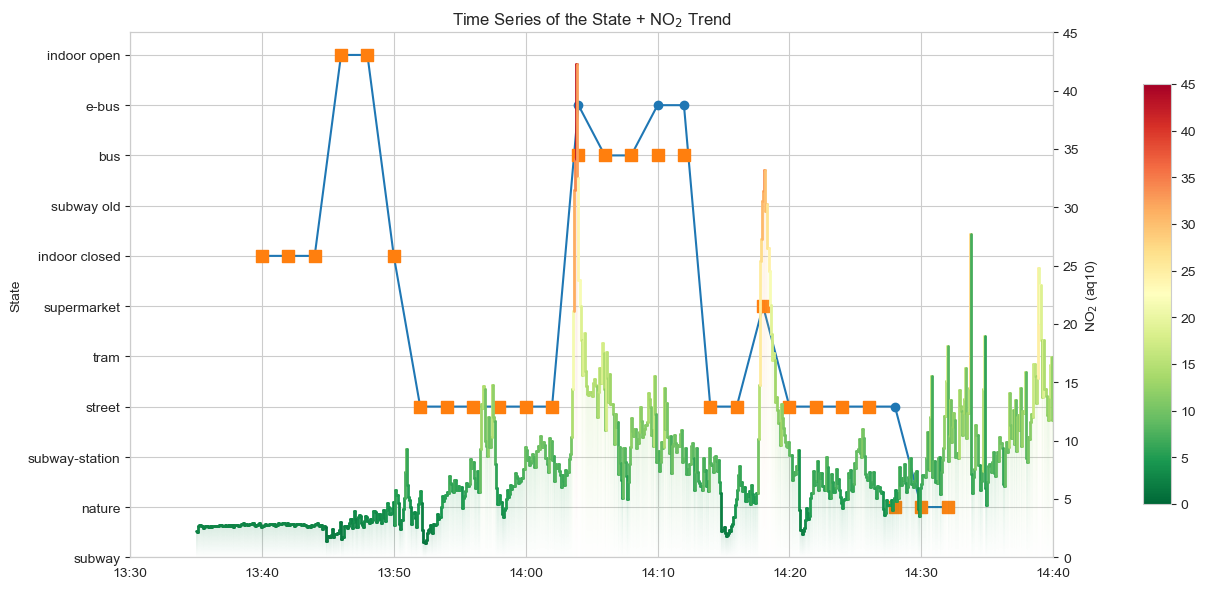

Datenbereich merged_df_filtered: 2025-02-18 13:40:00 2025-02-18 14:32:00
Datenbereich df_no2_filtered: 2025-02-18 13:35:00 2025-02-19 02:07:05


In [7]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# ------------------------------------------
# 1) CSVs loading (Predictions + NO₂)
# ------------------------------------------

# Pfade anpassen
CSV_PATH = r"C:\Users\lpera\Downloads\step1.csv"
MODEL_PATH = r"C:\Users\lpera\tf_nn_model.keras"
NO2_CSV_PATH = r"C:\Users\lpera\Downloads\NO2_airquix10-data-2025-02-19 04_01_12.csv"

# Label-Mapping
label_mapping = {
    "vehicle in subway": 0,
    "outdoor in nature": 1,
    "indoor in subway-station": 2,
    "outdoor on foot": 3,
    "vehicle in tram": 4,
    "indoor in supermarket": 5,
    "indoor with window closed": 6,
    "vehicle in subway (old)": 7,
    "vehicle in bus": 8,
    "vehicle in e-bus": 9,
    "indoor with window open": 10
}
inv_label_mapping = {v: k for k, v in label_mapping.items()}

short_label_mapping = {
    "vehicle in subway": "subway",
    "outdoor on foot": "street",
    "indoor in supermarket": "supermarket",
    "vehicle in tram": "tram",
    "indoor with window closed": "indoor closed",
    "indoor in subway-station": "subway-station",
    "vehicle in subway (old)": "subway old",
    "vehicle in bus": "bus",
    "vehicle in e-bus": "e-bus",
    "outdoor in nature": "nature",
    "indoor with window open": "indoor open"
}

# 1.1) Lade Predictions-CSV
df = pd.read_csv(CSV_PATH, delimiter=",", encoding="utf-8")
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['status_gt'] = df['status_gt'].astype(str).str.strip().str.lower()

# Bestimme Feature-Spalten
FEATURE_COLS = [col for col in df.columns if col not in ["timestamp", "status_gt"]]

# 1.2) Lade Keras Model
model = tf.keras.models.load_model(MODEL_PATH)
print("Model successfully loaded.")

# 1.3) Führe Inferenz für jede Zeile (5-Sek-Intervalle) durch
predictions = []
num_rows = len(df)
for i in range(num_rows):
    input_data = {}
    for col in FEATURE_COLS:
        value = df.loc[i, col]
        if np.issubdtype(df[col].dtype, np.number):
            input_data[col] = np.array([[value]], dtype=np.float32)
        else:
            input_data[col] = tf.convert_to_tensor([[str(value)]], dtype=tf.string)
    pred = model.predict(input_data)
    prob_vector = pred[0]
    pred_class = int(np.argmax(prob_vector))
    confidence = float(prob_vector[pred_class])
    predictions.append((df.loc[i, 'timestamp'], pred_class, confidence))

pred_df = pd.DataFrame(predictions, columns=['timestamp', 'pred_mode_class', 'confidence'])

# 1.4) Aggregiere Predictions pro 2 Minuten (Modus + avg_confidence)
pred_df['minute'] = pred_df['timestamp'].dt.floor('2min')
pred_minute = pred_df.groupby('minute').agg(
    pred_mode_class=pd.NamedAgg(column='pred_mode_class', aggfunc=lambda x: x.mode().iloc[0]),
    avg_confidence=pd.NamedAgg(column='confidence', aggfunc='mean')
).reset_index()

# 1.5) Aggregiere die Ground Truth (True State) pro 2 Minuten
df['true_status_num'] = df['status_gt'].map(label_mapping)
df['minute'] = df['timestamp'].dt.floor('2min')
true_minute = df.groupby('minute').agg(
    true_mode_status=pd.NamedAgg(
        column='true_status_num',
        aggfunc=lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
    )
).reset_index()

# 1.6) Lade NO₂-Daten (Rohdaten)
df_no2 = pd.read_csv(NO2_CSV_PATH, parse_dates=["Time"]).sort_values(by="Time")

# ------------------------------------------
# 2) Manueller Startzeit + Filter
# ------------------------------------------
manual_start_time = pd.Timestamp("2025-02-18 13:35:00")

# Merge: Vorhergesagte Klasse + Ground Truth (beide pro 2 Minuten)
merged_df = pd.merge(pred_minute, true_minute, on='minute', how='inner')

# Filter auf Daten nach der manuellen Startzeit
merged_df_filtered = merged_df[merged_df['minute'] >= manual_start_time].copy()

# NO₂ filtern (Rohdaten für den Gradient-Plot)
df_no2_filtered = df_no2[df_no2['Time'] >= manual_start_time].copy()
times_no2 = df_no2_filtered["Time"].to_numpy()
vals_no2  = df_no2_filtered["no2_aq10"].to_numpy()

# 2b) NO₂ auf 2-Minuten Intervall -> Mittelwert
df_no2_filtered['minute'] = df_no2_filtered['Time'].dt.floor('2min')
no2_agg_2min = df_no2_filtered.groupby('minute')['no2_aq10'].mean().reset_index()
no2_agg_2min.rename(columns={'no2_aq10': 'no2_mean'}, inplace=True)

# ------------------------------------------
# 3) Mittelwert + Std von NO₂ pro Klasse (optional)
# ------------------------------------------
stats_no2_per_class = pd.merge(
    merged_df_filtered[['minute', 'pred_mode_class']],
    no2_agg_2min,
    on='minute',
    how='inner'
).groupby('pred_mode_class')['no2_mean'].agg(['mean', 'std']).reset_index()
stats_no2_per_class['class_name'] = stats_no2_per_class['pred_mode_class'].map(inv_label_mapping)

print("\nMittelwert + Std NO₂ pro vorhergesagter Klasse:")
print(stats_no2_per_class)

# ------------------------------------------
# 4) Plot (Vergleich: Vorhersage vs. Ground Truth + NO₂ Gradient)
# ------------------------------------------
sns.set_style("whitegrid")
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))

# (A) Plot: Vorhersage (als Linie) und Ground Truth (als Scatter) auf der linken Achse
ax1.plot(
    merged_df_filtered['minute'],
    merged_df_filtered['pred_mode_class'],
    marker='o', linestyle='-', color='tab:blue',
    label='Predicted State (Mode)',
    zorder=10
)
ax1.scatter(
    merged_df_filtered['minute'],
    merged_df_filtered['true_mode_status'],
    color='tab:orange', marker='s', s=80,
    label='True State (Mode)',
    zorder=11
)
ax1.set_ylabel("State")
ax1.set_title("Time Series of the State + NO$_2$ Trend")

# Y-Ticks 0..10
all_classes = sorted(label_mapping.values())
ax1.set_yticks(all_classes)
ax1.set_yticklabels([
    short_label_mapping.get(inv_label_mapping.get(cls, "Unknown"), "Unknown")
    for cls in all_classes
])

# (B) NO₂ auf der rechten Achse (Gradient, basierend auf Rohdaten)
ax_no2 = ax1.twinx()
ax_no2.grid(False)

if len(times_no2) > 0:
    cmap = plt.get_cmap("RdYlGn_r")
    norm = plt.Normalize(0, 45)  # Farbskala 0..45
    n_stripes = 25
    ax_no2.set_ylim(0, 45)  # Rechte Achse: 0..45

    for i in range(len(vals_no2) - 1):
        x1_ = times_no2[i]
        x2_ = times_no2[i+1]
        y1_ = vals_no2[i]
        y2_ = vals_no2[i+1]

        # Horizontale Linie
        color_h = cmap(norm(min(y1_, 45)))
        ax_no2.plot([x1_, x2_], [y1_, y1_], color=color_h, linewidth=2, zorder=2)

        # Vertikale Linie
        color_v = cmap(norm(min(y2_, 45)))
        ax_no2.plot([x2_, x2_], [y1_, y2_], color=color_v, linewidth=2, zorder=2)

        # Füllung (Streifen)
        bottom_level = 0  
        top_level = y1_
        levels = np.linspace(bottom_level, top_level, n_stripes + 1)
        for s in range(n_stripes):
            bottom = levels[s]
            top = levels[s+1]
            alpha_val = 0.15 * ((s+1)/n_stripes)
            ax_no2.fill_between(
                [x1_, x2_], top, bottom,
                facecolor=color_h, alpha=alpha_val,
                edgecolor='none',
                zorder=1
            )

    ax_no2.set_ylabel("NO$_2$ (aq10)")
else:
    print("No NO$_2$ data available after manual_start_time.")
    ax_no2.set_ylabel("NO$_2$ (aq10)")

# ------------------------------------------
# 5) X-Achsen-Format & Colorbar
# ------------------------------------------
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

start_plot = pd.Timestamp("2025-02-18 13:30:00")
end_plot   = pd.Timestamp("2025-02-18 14:40:00")
ax1.set_xlim(start_plot, end_plot)

fig.tight_layout(rect=[0, 0, 0.8, 1])

# Colorbar (rechts)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
if len(times_no2) > 0:
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
else:
    sm = plt.cm.ScalarMappable()
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)

# X-Achse-Ticks drehen
fig.autofmt_xdate(rotation=45)

# 6) Plot speichern
plt.savefig("NO2_plot.png", dpi=300, bbox_inches="tight")

# 7) Plot anzeigen
plt.show()

# --- Zusätzlicher Datencheck ---
print("Datenbereich merged_df_filtered:", 
      merged_df_filtered['minute'].min(), 
      merged_df_filtered['minute'].max())
print("Datenbereich df_no2_filtered:", 
      df_no2_filtered['Time'].min(), 
      df_no2_filtered['Time'].max())


Model successfully loaded.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━

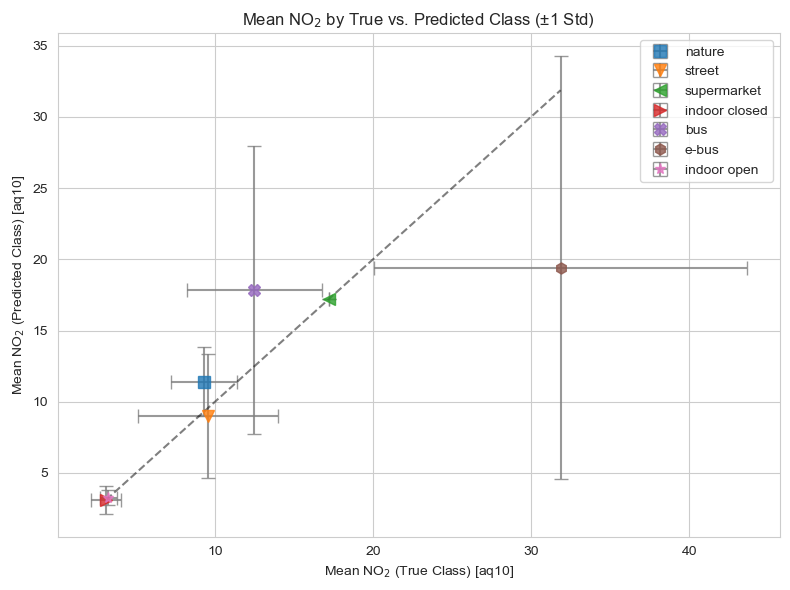

In [8]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------------
# 1) CSVs loading (Predictions + NO₂)
# -------------------------------------------------
# Pfade anpassen
CSV_PATH = r"C:\Users\lpera\Downloads\step3.csv"
MODEL_PATH = r"C:\Users\lpera\tf_nn_model.keras"
NO2_CSV_PATH = r"C:\Users\lpera\Downloads\NO2_airquix10-data-2025-02-19 04_01_12.csv"

# Prediction-Daten laden
df = pd.read_csv(CSV_PATH, delimiter=",", encoding="utf-8")
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['status_gt'] = df['status_gt'].astype(str).str.strip().str.lower()

# Label-Mapping
label_mapping = {
    "vehicle in subway": 0,
    "outdoor in nature": 1,
    "indoor in subway-station": 2,
    "outdoor on foot": 3,
    "vehicle in tram": 4,
    "indoor in supermarket": 5,
    "indoor with window closed": 6,
    "vehicle in subway (old)": 7,
    "vehicle in bus": 8,
    "vehicle in e-bus": 9,
    "indoor with window open": 10
}
inv_label_mapping = {v: k for k, v in label_mapping.items()}

# Optionale Kurz-Bezeichnungen
short_label_mapping = {
    "vehicle in subway": "subway",
    "outdoor on foot": "street",
    "indoor in supermarket": "supermarket",
    "vehicle in tram": "tram",
    "indoor with window closed": "indoor closed",
    "indoor in subway-station": "subway-station",
    "vehicle in subway (old)": "subway old",
    "vehicle in bus": "bus",
    "vehicle in e-bus": "e-bus",
    "outdoor in nature": "nature",
    "indoor with window open": "indoor open"
}

# Bestimme Feature-Spalten (alle außer timestamp und status_gt)
FEATURE_COLS = [col for col in df.columns if col not in ["timestamp", "status_gt"]]

# Keras Modell laden
model = tf.keras.models.load_model(MODEL_PATH)
print("Model successfully loaded.")

# -------------------------------------------------
# 2) Inferenz (5-Sekunden Takt) + Aggregation
# -------------------------------------------------
predictions = []
for i in range(len(df)):
    input_data = {}
    for col in FEATURE_COLS:
        value = df.loc[i, col]
        if np.issubdtype(df[col].dtype, np.number):
            input_data[col] = np.array([[value]], dtype=np.float32)
        else:
            input_data[col] = tf.convert_to_tensor([[str(value)]], dtype=tf.string)
    pred = model.predict(input_data)
    prob_vector = pred[0]
    pred_class = int(np.argmax(prob_vector))
    confidence = float(prob_vector[pred_class])
    predictions.append((df.loc[i, 'timestamp'], pred_class, confidence))

pred_df = pd.DataFrame(predictions, columns=['timestamp', 'pred_mode_class', 'confidence'])

# Aggregation auf 2-Minuten-Basis: Berechnung des Modus (vorhergesagte Klasse) und mittlere Confidence
pred_df['minute'] = pred_df['timestamp'].dt.floor('2min')
pred_minute = pred_df.groupby('minute').agg(
    pred_mode_class=pd.NamedAgg(column='pred_mode_class', aggfunc=lambda x: x.mode().iloc[0]),
    avg_confidence=pd.NamedAgg(column='confidence', aggfunc='mean')
).reset_index()

# -------------------------------------------------
# 3) Ground Truth auf 2-Minuten-Basis
# -------------------------------------------------
# Numerische Kodierung der Ground Truth
df['true_status_num'] = df['status_gt'].map(label_mapping)
df['minute'] = df['timestamp'].dt.floor('2min')
true_minute = df.groupby('minute').agg(
    true_mode_status=pd.NamedAgg(column='true_status_num', aggfunc=lambda x: x.mode().iloc[0])
).reset_index()

# -------------------------------------------------
# 4) NO₂-Daten laden und auf 2-Minuten-Mittelwerte aggregieren
# -------------------------------------------------
df_no2 = pd.read_csv(NO2_CSV_PATH, parse_dates=["Time"]).sort_values(by="Time")
manual_start_time = pd.Timestamp("2025-02-18 13:30:00")

# Filter: nur Daten ab der manuellen Startzeit
pred_minute_filtered = pred_minute[pred_minute['minute'] >= manual_start_time].copy()
true_minute_filtered = true_minute[true_minute['minute'] >= manual_start_time].copy()

df_no2_filtered = df_no2[df_no2['Time'] >= manual_start_time].copy()
df_no2_filtered['minute'] = df_no2_filtered['Time'].dt.floor('2min')
no2_agg_2min = df_no2_filtered.groupby('minute')['no2_aq10'].mean().reset_index()
no2_agg_2min.rename(columns={'no2_aq10': 'no2_mean'}, inplace=True)

# -------------------------------------------------
# 5) Merge: NO₂ + Predictions und NO₂ + Ground Truth
# -------------------------------------------------
merged_pred = pd.merge(
    pred_minute_filtered[['minute','pred_mode_class']],
    no2_agg_2min,
    on='minute',
    how='inner'
)

merged_true = pd.merge(
    true_minute_filtered[['minute','true_mode_status']],
    no2_agg_2min,
    on='minute',
    how='inner'
)

# -------------------------------------------------
# 6) Berechnung von Statistiken (NO₂):
#     separate Tabellen für Predicted und True,
#     anschließende Zusammenführung (stats_both)
# -------------------------------------------------
stats_pred = merged_pred.groupby('pred_mode_class')['no2_mean'].agg(['mean','std']).reset_index()
stats_pred.rename(columns={'mean':'mean_pred','std':'std_pred','pred_mode_class':'class_id'}, inplace=True)

stats_true = merged_true.groupby('true_mode_status')['no2_mean'].agg(['mean','std']).reset_index()
stats_true.rename(columns={'mean':'mean_true','std':'std_true','true_mode_status':'class_id'}, inplace=True)

# Zusammenführen beider Statistik-Tabellen
stats_both = pd.merge(stats_pred, stats_true, on='class_id', how='outer').fillna(0)
stats_both.sort_values(by='class_id', inplace=True)

print("\nNO2 Stats Both (Predicted vs. True):\n", stats_both)

# -------------------------------------------------
# 7) Scatter-Plot: x = Mean True, y = Mean Pred (mit Fehlerbalken)
# -------------------------------------------------
markers = ["o", "s", "^", "v", "D", "<", ">", "p", "X", "h", "*"]

def get_short_label(class_id):
    c_int = int(class_id)
    original_name = inv_label_mapping.get(c_int, "Unknown")
    return short_label_mapping.get(original_name, original_name)

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8, 6))

for i, row in stats_both.iterrows():
    c = row['class_id']
    c_int = int(c)
    x = row['mean_true']
    y = row['mean_pred']
    xerr = row['std_true']
    yerr = row['std_pred']
    marker_c = markers[c_int] if c_int < len(markers) else "o"
    label_c = get_short_label(c_int)
    
    ax.errorbar(
        x, y,
        xerr=xerr, yerr=yerr,
        fmt=marker_c, capsize=5,
        ecolor='gray', markersize=8,
        alpha=0.8,
        label=label_c
    )

# Diagonale y=x zur Referenz
all_x = stats_both['mean_true']
all_y = stats_both['mean_pred']
min_val = min(all_x.min(), all_y.min())
max_val = max(all_x.max(), all_y.max())
ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)

ax.set_xlabel("Mean NO$_2$ (True Class) [aq10]")
ax.set_ylabel("Mean NO$_2$ (Predicted Class) [aq10]")
ax.set_title("Mean NO$_2$ by True vs. Predicted Class (±1 Std)")

ax.legend(loc='best')
plt.tight_layout()
plt.savefig("mean_NO2_pred_vs_true.png", dpi=300, bbox_inches="tight")
plt.show()


Model successfully loaded.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━

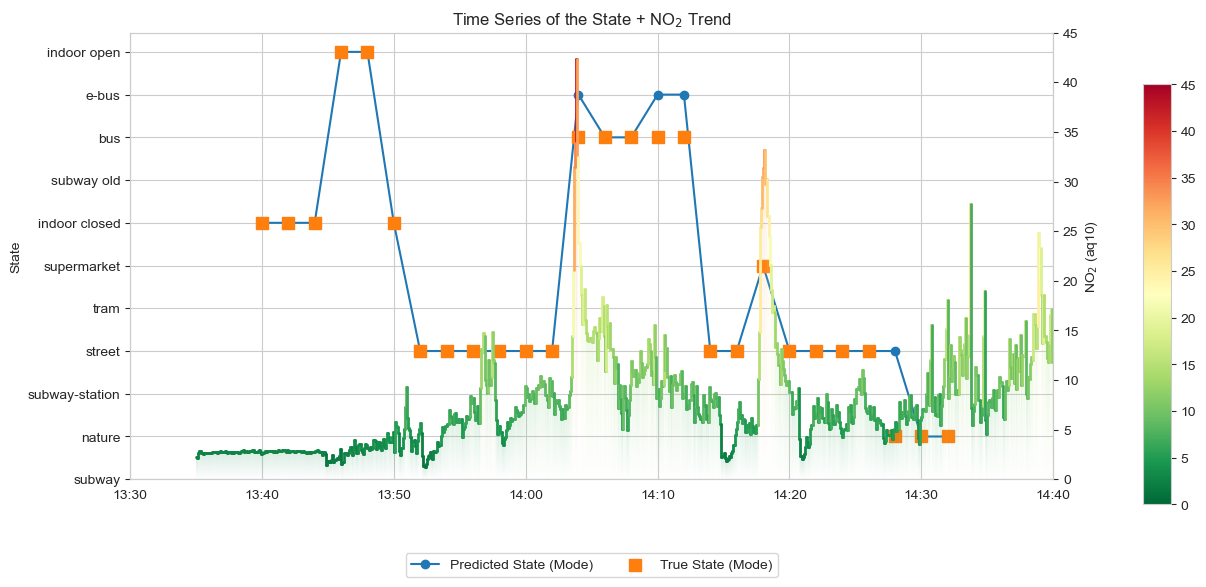

Datenbereich merged_df_filtered: 2025-02-18 13:40:00 2025-02-18 14:32:00
Datenbereich df_no2_filtered: 2025-02-18 13:35:00 2025-02-19 02:07:05


In [9]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# ------------------------------------------
# 1) CSVs loading (Predictions + NO₂)
# ------------------------------------------

# Pfade anpassen
CSV_PATH = r"C:\Users\lpera\Downloads\step1.csv"
MODEL_PATH = r"C:\Users\lpera\tf_nn_model.keras"
NO2_CSV_PATH = r"C:\Users\lpera\Downloads\NO2_airquix10-data-2025-02-19 04_01_12.csv"

# Label-Mapping
label_mapping = {
    "vehicle in subway": 0,
    "outdoor in nature": 1,
    "indoor in subway-station": 2,
    "outdoor on foot": 3,
    "vehicle in tram": 4,
    "indoor in supermarket": 5,
    "indoor with window closed": 6,
    "vehicle in subway (old)": 7,
    "vehicle in bus": 8,
    "vehicle in e-bus": 9,
    "indoor with window open": 10
}
inv_label_mapping = {v: k for k, v in label_mapping.items()}

short_label_mapping = {
    "vehicle in subway": "subway",
    "outdoor on foot": "street",
    "indoor in supermarket": "supermarket",
    "vehicle in tram": "tram",
    "indoor with window closed": "indoor closed",
    "indoor in subway-station": "subway-station",
    "vehicle in subway (old)": "subway old",
    "vehicle in bus": "bus",
    "vehicle in e-bus": "e-bus",
    "outdoor in nature": "nature",
    "indoor with window open": "indoor open"
}

# 1.1) Lade Predictions-CSV
df = pd.read_csv(CSV_PATH, delimiter=",", encoding="utf-8")
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['status_gt'] = df['status_gt'].astype(str).str.strip().str.lower()

# Bestimme Feature-Spalten
FEATURE_COLS = [col for col in df.columns if col not in ["timestamp", "status_gt"]]

# 1.2) Lade Keras Model
model = tf.keras.models.load_model(MODEL_PATH)
print("Model successfully loaded.")

# 1.3) Führe Inferenz für jede Zeile (5-Sek-Intervalle) durch
predictions = []
num_rows = len(df)
for i in range(num_rows):
    input_data = {}
    for col in FEATURE_COLS:
        value = df.loc[i, col]
        if np.issubdtype(df[col].dtype, np.number):
            input_data[col] = np.array([[value]], dtype=np.float32)
        else:
            input_data[col] = tf.convert_to_tensor([[str(value)]], dtype=tf.string)
    pred = model.predict(input_data)
    prob_vector = pred[0]
    pred_class = int(np.argmax(prob_vector))
    confidence = float(prob_vector[pred_class])
    predictions.append((df.loc[i, 'timestamp'], pred_class, confidence))

pred_df = pd.DataFrame(predictions, columns=['timestamp', 'pred_mode_class', 'confidence'])

# 1.4) Aggregiere Predictions pro 2 Minuten (Modus + avg_confidence)
pred_df['minute'] = pred_df['timestamp'].dt.floor('2min')
pred_minute = pred_df.groupby('minute').agg(
    pred_mode_class=pd.NamedAgg(column='pred_mode_class', aggfunc=lambda x: x.mode().iloc[0]),
    avg_confidence=pd.NamedAgg(column='confidence', aggfunc='mean')
).reset_index()

# 1.5) Aggregiere die Ground Truth (True State) pro 2 Minuten
df['true_status_num'] = df['status_gt'].map(label_mapping)
df['minute'] = df['timestamp'].dt.floor('2min')
true_minute = df.groupby('minute').agg(
    true_mode_status=pd.NamedAgg(
        column='true_status_num',
        aggfunc=lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
    )
).reset_index()

# 1.6) Lade NO₂-Daten (Rohdaten)
df_no2 = pd.read_csv(NO2_CSV_PATH, parse_dates=["Time"]).sort_values(by="Time")

# ------------------------------------------
# 2) Manueller Startzeit + Filter
# ------------------------------------------
manual_start_time = pd.Timestamp("2025-02-18 13:35:00")

# Merge: Vorhergesagte Klasse + Ground Truth (beide pro 2 Minuten)
merged_df = pd.merge(pred_minute, true_minute, on='minute', how='inner')

# Filter auf Daten nach der manuellen Startzeit
merged_df_filtered = merged_df[merged_df['minute'] >= manual_start_time].copy()

# NO₂ filtern (Rohdaten für den Gradient-Plot)
df_no2_filtered = df_no2[df_no2['Time'] >= manual_start_time].copy()
times_no2 = df_no2_filtered["Time"].to_numpy()
vals_no2  = df_no2_filtered["no2_aq10"].to_numpy()

# 2b) NO₂ auf 2-Minuten Intervall -> Mittelwert
df_no2_filtered['minute'] = df_no2_filtered['Time'].dt.floor('2min')
no2_agg_2min = df_no2_filtered.groupby('minute')['no2_aq10'].mean().reset_index()
no2_agg_2min.rename(columns={'no2_aq10': 'no2_mean'}, inplace=True)

# ------------------------------------------
# 3) Mittelwert + Std von NO₂ pro Klasse (optional)
# ------------------------------------------
stats_no2_per_class = pd.merge(
    merged_df_filtered[['minute', 'pred_mode_class']],
    no2_agg_2min,
    on='minute',
    how='inner'
).groupby('pred_mode_class')['no2_mean'].agg(['mean', 'std']).reset_index()
stats_no2_per_class['class_name'] = stats_no2_per_class['pred_mode_class'].map(inv_label_mapping)

print("\nMittelwert + Std NO₂ pro vorhergesagter Klasse:")
print(stats_no2_per_class)

# ------------------------------------------
# 4) Plot (Vergleich: Vorhersage vs. Ground Truth + NO₂ Gradient)
# ------------------------------------------
sns.set_style("whitegrid")
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))

# (A) Plot: Vorhersage (als Linie) und Ground Truth (als Scatter) auf der linken Achse
ax1.plot(
    merged_df_filtered['minute'],
    merged_df_filtered['pred_mode_class'],
    marker='o', linestyle='-', color='tab:blue',
    label='Predicted State (Mode)',
    zorder=10
)
ax1.scatter(
    merged_df_filtered['minute'],
    merged_df_filtered['true_mode_status'],
    color='tab:orange', marker='s', s=80,
    label='True State (Mode)',
    zorder=11
)
ax1.set_ylabel("State")
ax1.set_title("Time Series of the State + NO$_2$ Trend")

# Legende hinzufügen (wie im CO₂-Code, unten mittig)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

# Y-Ticks 0..10
all_classes = sorted(label_mapping.values())
ax1.set_yticks(all_classes)
ax1.set_yticklabels([
    short_label_mapping.get(inv_label_mapping.get(cls, "Unknown"), "Unknown")
    for cls in all_classes
])

# (B) NO₂ auf der rechten Achse (Gradient, basierend auf Rohdaten)
ax_no2 = ax1.twinx()
ax_no2.grid(False)

if len(times_no2) > 0:
    cmap = plt.get_cmap("RdYlGn_r")
    norm = plt.Normalize(0, 45)  # Farbskala 0..45
    n_stripes = 25
    ax_no2.set_ylim(0, 45)  # Rechte Achse: 0..45

    for i in range(len(vals_no2) - 1):
        x1_ = times_no2[i]
        x2_ = times_no2[i+1]
        y1_ = vals_no2[i]
        y2_ = vals_no2[i+1]

        # Horizontale Linie
        color_h = cmap(norm(min(y1_, 45)))
        ax_no2.plot([x1_, x2_], [y1_, y1_], color=color_h, linewidth=2, zorder=2)

        # Vertikale Linie
        color_v = cmap(norm(min(y2_, 45)))
        ax_no2.plot([x2_, x2_], [y1_, y2_], color=color_v, linewidth=2, zorder=2)

        # Füllung (Streifen)
        bottom_level = 0  
        top_level = y1_
        levels = np.linspace(bottom_level, top_level, n_stripes + 1)
        for s in range(n_stripes):
            bottom = levels[s]
            top = levels[s+1]
            alpha_val = 0.15 * ((s+1)/n_stripes)
            ax_no2.fill_between(
                [x1_, x2_], top, bottom,
                facecolor=color_h, alpha=alpha_val,
                edgecolor='none',
                zorder=1
            )

    ax_no2.set_ylabel("NO$_2$ (aq10)")
else:
    print("No NO$_2$ data available after manual_start_time.")
    ax_no2.set_ylabel("NO$_2$ (aq10)")

# ------------------------------------------
# 5) X-Achsen-Format & Colorbar
# ------------------------------------------
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

start_plot = pd.Timestamp("2025-02-18 13:30:00")
end_plot   = pd.Timestamp("2025-02-18 14:40:00")
ax1.set_xlim(start_plot, end_plot)

fig.tight_layout(rect=[0, 0, 0.8, 1])

# Colorbar (rechts)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
if len(times_no2) > 0:
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
else:
    sm = plt.cm.ScalarMappable()
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)

# X-Achse-Ticks drehen
fig.autofmt_xdate(rotation=45)

# 6) Plot speichern
plt.savefig("NO2_plot.png", dpi=300, bbox_inches="tight")

# 7) Plot anzeigen
plt.show()

# --- Zusätzlicher Datencheck ---
print("Datenbereich merged_df_filtered:", 
      merged_df_filtered['minute'].min(), 
      merged_df_filtered['minute'].max())
print("Datenbereich df_no2_filtered:", 
      df_no2_filtered['Time'].min(), 
      df_no2_filtered['Time'].max())
